# Laboratorio 3 Data Science S10
- Arturo Argueta
- Astrid Glauser


In [15]:
import pandas as pd

In [17]:
# Carga de los conjutos de prueba y testing para ambos archivos
# Identicos al laboratorio Anterior

importacion_df = pd.read_excel('importacion.xlsx', skiprows=6)
importacion_df.columns = [
    'Fecha', 'AceitesLubricantes', 'Asfalto', 'Bunker', 'Ceras', 
    'CombustibleTurboJet', 'DieselLS', 'DieselUltraLS', 'GasLicuado', 
    'GasolinaAviacion', 'GasolinaRegular', 'GasolinaSuper', 'Kerosina', 
    'MTBE', 'Naftas', 'Petcoke', 'PetroleoCrudo', 'Solventes', 
    'Butano', 'DieselAltoAzufre', 'Orimulsion', 'PetroleoReconstituido', 
    'TotalImportacion', 'ColumnaExtra1', 'ColumnaExtra2'
]

# Convertir la columna de fechas a formato datetime
importacion_df['Fecha'] = pd.to_datetime(importacion_df['Fecha'], errors='coerce')
importacion_df = importacion_df.dropna()
#usar solo las columnas de interés ( 'GasolinaRegular', 'GasolinaSuper', 'DieselLS ,'DieselUltraLS', 'GasLicuado' y la Fecha)
importacion_df = importacion_df[['Fecha','GasolinaRegular', 'GasolinaSuper', 'DieselLS' ,'DieselUltraLS', 'GasLicuado']]
importacion_df.head()



,Fecha,GasolinaRegular,GasolinaSuper,DieselLS,DieselUltraLS,GasLicuado
0,2001-01-01,177776.50,373963.96,0.0,0.0,194065.738095
1,2001-02-01,123115.99,243091.07,0.0,0.0,170703.380952
2,2001-03-01,161726.42,312084.38,0.0,0.0,161837.371429
3,2001-04-01,127338.74,285054.89,0.0,0.0,163048.642857
4,2001-05-01,168730.19,300913.67,0.0,0.0,171518.861905


In [23]:
#Separar en Train y Test usando esta fecha:
split_date = '2021-01-01'
print(importacion_df.shape)
#calcular el index para separar al normalizar los valores:
split_index = importacion_df[importacion_df['Fecha'] == split_date].index.tolist()[0]
split_index

(280, 6)


240

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras

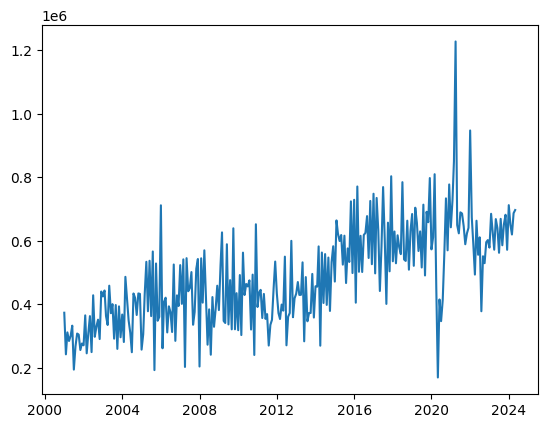

In [11]:
# Prediccion de la gasolina super
super_gas_df = importacion_df[['Fecha','GasolinaSuper']]
super_gas_df = super_gas_df.set_index('Fecha')
plt.plot(super_gas_df)

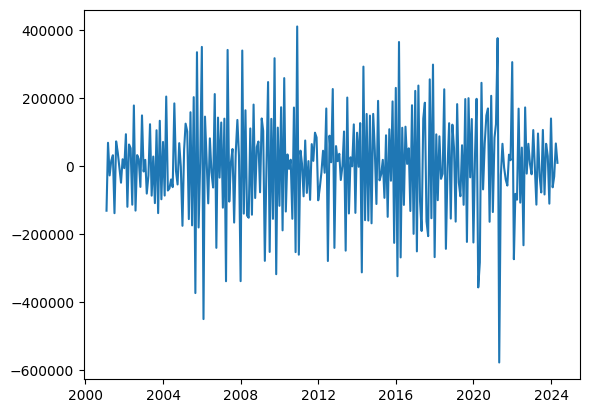

In [12]:
super_gas_diff = super_gas_df.diff()
plt.plot(super_gas_diff)

In [26]:
# normalizar los datos para el LSTM
scaler = StandardScaler()
super_gas_scaled = scaler.fit_transform(super_gas_diff) 
print(super_gas_scaled[1:7])

#separar en test y prueba
super_gas_train = super_gas_scaled[:split_index]
super_gas_test = super_gas_scaled[split_index:]

[[-0.82884453]
 [ 0.42584933]
 [-0.17695003]
 [ 0.09228833]
 [ 0.19552297]
 [-0.8744985 ]]


In [29]:
#transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente
from operator import concat
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

super_gas_x_train,super_gas_y_train = supervisada(super_gas_train)
super_gas_test_x_test,super_gas_test_y_test = supervisada(super_gas_test)

#convertir en arreglos tridimensionales donde cada una es "muestras", "tiempo", "features"
super_gas_x_train = np.reshape(super_gas_x_train,(super_gas_x_train.shape[0],1,1))
super_gas_test_x_test = np.reshape(super_gas_test_x_test, (super_gas_test_x_test.shape[0],1,1))

In [32]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 1)                 12        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
epocas = 50
history= modelo1.fit(
    x = super_gas_x_train,
    y = super_gas_y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    verbose=1
)

Epoch 1/50
239/239 [==============================] - 4s 3ms/step - loss: nan
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: nan
Epoch 3/50
239/239 [==============================] - 1s 4ms/step - loss: nan
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: nan
Epoch 5/50
239/239 [==============================] - 1s 2ms/step - loss: nan
Epoch 6/50
239/239 [==============================] - 1s 2ms/step - loss: nan
Epoch 7/50
239/239 [==============================] - 1s 2ms/step - loss: nan
Epoch 8/50
239/239 [==============================] - 0s 1ms/step - loss: nan
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: nan
Epoch 10/50
239/239 [==============================] - 0s 2ms/step - loss: nan
Epoch 11/50
239/239 [==============================] - 1s 2ms/step - loss: nan
Epoch 12/50
239/239 [==============================] - 1s 2ms/step - loss: nan
Epoch 13/50
239/239 [==============================] - 0s 2ms

In [38]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_test = prediccion_fun(super_gas_test_x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = super_gas_df.values , n = len(super_gas_test_x_test))

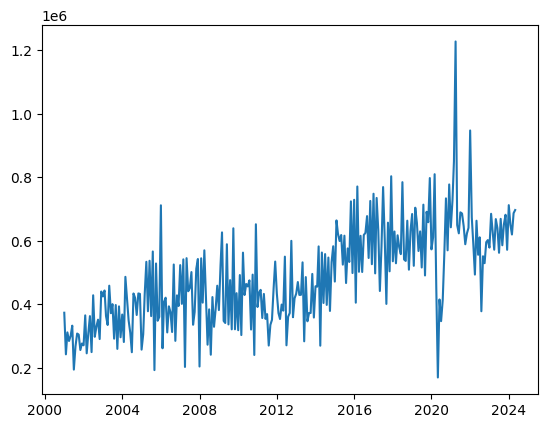

In [40]:
df_test = pd.DataFrame(prediccion_test,index=super_gas_df[split_index + 1:len(super_gas_df)].index)
# plt.plot(super_gas_df)
plt.plot(df_test)